# Getting started with exploratory data analysis

## Install and import required libraries

In [4]:
%bash
pip install sns

### NOTE 
Run below cell whenever you restart the session

In [8]:
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
import numpy as np
import google.datalab.bigquery as bq
import warnings

# Disable warnings
warnings.filterwarnings('ignore')

## Sampling data using bigquery

First check total number of rows we have in our table.

In [68]:
%bigquery execute -d standard
SELECT COUNT(DEP_DELAY) FROM flights.simevents

f0_
2209776


We will use [RAND](https://cloud.google.com/bigquery/docs/reference/standard-sql/functions-and-operators#rand) to get random sample from uniformely distributed dataset.
Lets check how accurate the query is.

In [71]:
%bigquery execute -d standard 
SELECT COUNT(*) FROM flights.simevents WHERE RAND() < 0.01

f0_
22117


Looks quite accurate. Try with the code now.
Our goal is to find the 30% chance of arrival delay is 15 min late. From chapter 3 that is departure delay of 10 min .
Will look into more depth with arrival delay for datasets that has departure delay larger than 10 min.

In [6]:
# 

sql = """
SELECT ARR_DELAY, DEP_DELAY
FROM `flights.fedtzcorr`
WHERE DEP_DELAY > 10 AND RAND() < 0.01
"""

df = bq.Query(sql).execute().result().to_dataframe()
df.describe()

,ARR_DELAY,DEP_DELAY
count,1696.000000,1703.000000
mean,-8.790094,-2.825602
std,14.193963,4.820954
min,-57.000000,-24.000000
25%,-17.000000,-6.000000
50%,-10.000000,-3.000000
75%,-2.000000,0.000000
max,118.000000,9.000000


## Check probability distribution for arrival delay using violin plot.

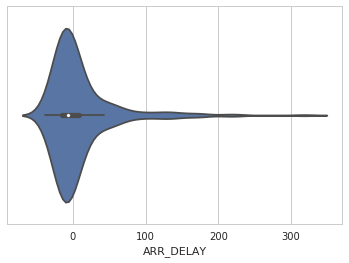

In [9]:
sb.set_style("whitegrid")
ax = sb.violinplot(data=df, x='ARR_DELAY', inner='box', orient='h')

## Explore arrival delays
Here, I will compare the probability for arrival delay between datasets that has less than 10 min delay and more than 10 min delay.

(-50, 200)

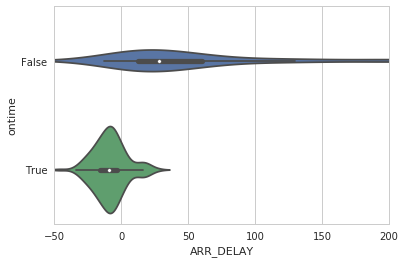

In [15]:
# Pull random 1% sample from the dataset

sql = """
SELECT ARR_DELAY, DEP_DELAY
FROM `flights.fedtzcorr`
WHERE RAND() < 0.001
"""

df = bq.Query(sql).execute().result().to_dataframe()

# Threshold comparison will be done in the code.
# Mark column "ontime" as TRUE when the departure delay is less than 10 min
df['ontime'] = df['DEP_DELAY'] < 10

sb.set_style("whitegrid")
ax = sb.violinplot(data=df, x='ARR_DELAY', y='ontime', inner='box', orient='h', gridsize=1000)
ax.set_xlim(-50, 200)

## (ONGOING) Add quality control
Here, I will explore how arrival delays are distributed against departure delay.

In [21]:
%bigquery execute -d standard
SELECT
  DEP_DELAY as dep_delay_in_minutes,
  AVG(ARR_DELAY) AS arrival_delay_in_minutes,
  COUNT(ARR_DELAY) AS numflights
FROM flights.simevents
GROUP BY DEP_DELAY
ORDER BY DEP_DELAY

dep_delay_in_minutes,arrival_delay_in_minutes,numflights
,-9.70798319327731,952
-50.0,-38.0,2
-49.0,-59.5,4
-46.0,-28.5,4
-45.0,-44.0,4
-43.0,-53.0,4
-42.0,-35.0,6
-40.0,-26.0,4
-39.0,-33.5,4
-38.0,-21.5,4


(-20, 0)

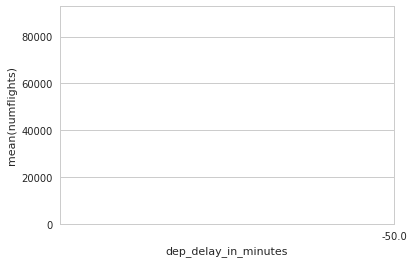

In [33]:
sql="""
SELECT
  DEP_DELAY as dep_delay_in_minutes,
  AVG(ARR_DELAY) AS arrival_delay_in_minutes,
  COUNT(ARR_DELAY) AS numflights
FROM flights.simevents
GROUP BY DEP_DELAY
ORDER BY DEP_DELAY
"""

df = bq.Query(sql).execute().result().to_dataframe()

ax = sb.barplot(data=df, x='dep_delay_in_minutes', y='numflights')
ax.set_xlim(-20,0)

## (TODO) Find oddball values

## (TODO) Finding outlier

## (TODO) Find data by occurence frequency

## (TODO) Conditioning arrival delay based on departure delay

## (TODO) Apply probalistic decision threshold

## (TODO) Apply empirical probability distribution function

## (TODO) Evaluate model

## (TODO) Train and test